In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from tqdm import tqdm
from transformers import pipeline
from transformers import AutoModel, AutoTokenizer
import numpy as np
import torch
from tqdm import tqdm
from tqdm import trange
from transformers import pipeline
from itertools import combinations
import matplotlib.pyplot as plt
import scipy
import torch
import pickle
from datasets import load_dataset
import nltk
import random
import torch.nn as nn
import sys

In [3]:
# this is the only available pre-training dataset of roberta
# other datasets are not available with the streaming option
# https://huggingface.co/docs/datasets/stream
dataset = load_dataset("stsb_multi_mt", "en", "train")

Using custom data configuration en-data_dir=train
Reusing dataset stsb_multi_mt (/root/.cache/huggingface/datasets/stsb_multi_mt/en-data_dir=train/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
sents = []

for d in dataset:
    for pair in dataset[d]:
        sents.append(pair["sentence1"])
        sents.append(pair["sentence2"])

print(f"Total number of sentences: {len(sents)}")

# for better batching, BERT and RoBERTa does not significantly differ
tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/sup-simcse-roberta-base")
sorted_sents = sorted(sents, key = lambda x: len(tokenizer(x)["input_ids"]))

Total number of sentences: 17256


In [5]:
# get the device
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [6]:
# define cosine similarity
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

In [7]:
# the name of the saved file
save_file = f"/content/drive/MyDrive/yearly-bias/results/anisotropy-all-SimCSEs.pkl"

100%|██████████| 13/13 [01:29<00:00,  6.87s/it]


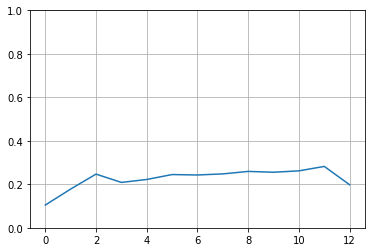

100%|██████████| 13/13 [01:26<00:00,  6.62s/it]


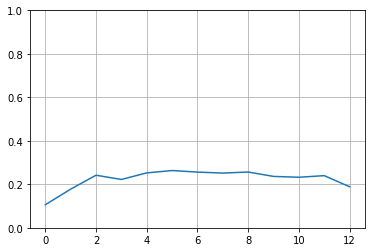

100%|██████████| 13/13 [01:29<00:00,  6.89s/it]


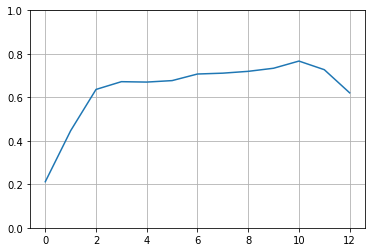

100%|██████████| 13/13 [01:25<00:00,  6.59s/it]


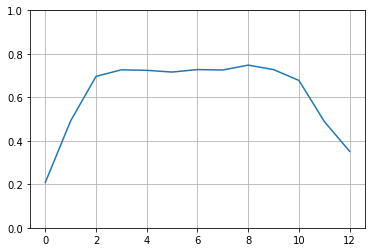

In [8]:
# total number of available layers
nol = 13

all_self_sims = []

# for reproducible sample
torch.manual_seed(42)

# all SimCSE models, no roberta-large because the number of layers do not agree
modelnames = [
    "princeton-nlp/sup-simcse-bert-base-uncased",
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "princeton-nlp/sup-simcse-roberta-base",
    "princeton-nlp/unsup-simcse-roberta-base"
]

for modelname in modelnames:

    # do not use the masked version of AutoModel
    model = AutoModel.from_pretrained(modelname).to(device)
    tokenizer = AutoTokenizer.from_pretrained(modelname)

    # save embeddings of all sentences
    all_embeddings = [[] for _ in range(nol)]

    # the chunk size for the encoding model
    chunk_size = 50

    # use only part of the sentences as a very rough estimate
    # results do not seem to qualitatively differ
    for i in tqdm(range(0, len(sorted_sents), chunk_size)):
        chunk = sorted_sents[i: i + chunk_size]
        encoded_input = tokenizer(chunk, padding=True, return_tensors='pt').to(device)
        lens = torch.sum(encoded_input.attention_mask, dim = 1)
        with torch.no_grad():
            model_output = model(**encoded_input, output_hidden_states=True)

        # sample one word from one sentence
        s = encoded_input.attention_mask.sum(axis=1).shape
        idx = (torch.rand(s).to(device) * encoded_input.attention_mask.sum(axis=1)).long()

        for j in range(13):
            # sentence id and word id
            for si, wi in enumerate(idx):
                all_embeddings[j].append(model_output.hidden_states[j][si, wi])

    # the coefficient
    n = len(all_embeddings[0])
    coef = (n**2 - n) / 2

    self_sims = []
    for j in trange(13):
        # get pairwise cosine similarity
        # matrix too large, have to put on cpu
        embs = torch.stack(all_embeddings[j]).to("cpu")
        lembs = torch.linalg.norm(embs, dim = 1)
        pcos = (embs @ embs.T) / (lembs * lembs[:,None])

        # coef terms in total
        self_sim = torch.sum(torch.triu(pcos, diagonal=1))

        self_sims.append(self_sim.item() / coef)

    plt.plot(self_sims)
    plt.ylim(0, 1)
    plt.title("")
    plt.grid()
    plt.show()

    # saving the data
    all_self_sims.append(self_sims)

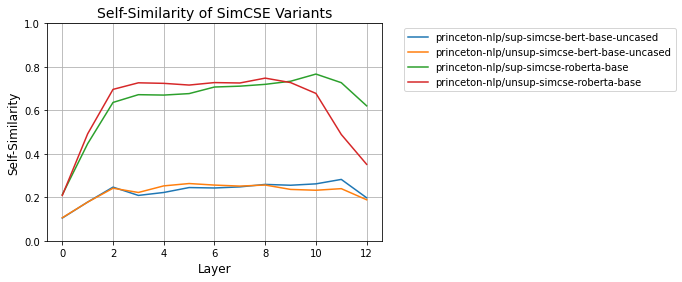

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))

for modelname, result in zip(modelnames, all_self_sims):
    plt.plot(result, label=modelname)

ax.set_xlabel("Layer", fontsize=12)
ax.set_ylabel("Self-Similarity", fontsize=12)
ax.set_title("Self-Similarity of SimCSE Variants", fontsize=14)
ax.set_ylim(0,1)
ax.legend(loc='upper left', bbox_to_anchor = (1.05, 1.0))
ax.grid()
plt.show()

In [10]:
with open(save_file, "wb") as f:
    pickle.dump(all_self_sims, f)